# Fine-Tuning a Generative Pretrained Transformer (`GPT`)

1. Install required libraries.

In [1]:
!pip install transformers datasets codecarbon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 100.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.0/176.0 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.2 MB/s eta 0:00:00


2. Load the data from the hub.

In [3]:
import pandas as pd
from datasets import load_dataset

dataset = load_dataset("nicholasKluge/instruct-aira-dataset", split='aira_instruct_english')

df = dataset.to_pandas()
df = df.sample(frac=1)
df = df.reset_index(drop=True)

display(df)

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating aira_english split:   0%|          | 0/9183 [00:00<?, ? examples/s]

Generating aira_instruct_english split:   0%|          | 0/48666 [00:00<?, ? examples/s]

Generating aira_instruct_portuguese split:   0%|          | 0/48571 [00:00<?, ? examples/s]

Generating aira_portuguese split:   0%|          | 0/9204 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/nicholasKluge___parquet/nicholasKluge--fine-tuning-instruct-aira-4077fd700c38fc36/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7. Subsequent calls will reuse this data.


prompt  \
0      What is the best way to find cheap flights to ...   
1      What is the best way to communicate in a remot...   
2      What are the best books to read if I want to l...   
3      Give me a list of what to do with used brake r...   
4                           How do I get rid of bedbugs.   
...                                                  ...   
48661              How do I get stains out of my carpet.   
48662  I would like to make an omelet for my dinner. ...   
48663    What are the best restaurants in San Francisco.   
48664      What is the best way to clean a leather sofa.   
48665                       Why do people have children?   

                                              completion  
0      The best way to find cheap flights to New York...  
1      The best way to communicate in a remote workpl...  
2      The best books to read if you want to learn ab...  
3      Scrap them for their raw metal value.  Use the...  
4      Start by thoroughly cleaning your home. Vacuum...  
...                                                  ...  
48661  The best way to get stains out of your carpet ...  
48662  Crack two eggs into a bowl.\n2. Whisk the eggs...  
48663  The top rated restaurants in San Francisco inc...  
48664  The best way to clean a leather sofa is to use...  
48665  There are many reasons people have children.  ...  

[48666 rows x 2 columns]

3. Load `GPT2Tokenizer` and add the chosen special tokens (`'<|startoftext|>', '<|endoftext|>','<|pad|>'`)
4. Create demonstrations by prepending the special tokens.
5. Calculate the maximum length (in tokens) that the demonstrations have (the dataset was constructed, for efficiency and fast training, to be below the 300-token range).

In [4]:
from transformers import GPT2Tokenizer

model = "gpt2-large" # "gpt2", "gpt2-medium", "gpt2-large", "gpt2-xl", "pierreguillou/gpt2-small-portuguese"
model_size = "774M" # "124M", "355M", "774M", and "1.5B", "PT-124M"

tokenizer = GPT2Tokenizer.from_pretrained(model,
                                          bos_token='<|startoftext|>',
                                          eos_token='<|endoftext|>',
                                          pad_token='<|pad|>')

df['demonstrations'] = tokenizer.bos_token + df['prompt'] + tokenizer.eos_token + df['completion'] + tokenizer.eos_token

df['length'] = df['demonstrations'].apply(lambda x: len(tokenizer.encode(x)))

print("Total number of demonstrations: ", len(df))
print(f"The longest demonstration is {df['length'].max()} tokens long.")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Total number of demonstrations:  48666
The longest demonstration is 300 tokens long.


6. Create the Dataset class.

In [5]:
import torch
from torch.utils.data import Dataset

max_length = 300

class DemoDataset(Dataset):

  def __init__(self, demonstrations, tokenizer, max_length=max_length):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for demo in demonstrations:

      encodings_dict = tokenizer(demo,
                                 truncation=True,
                                 max_length=max_length,
                                 padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

7. Split the data into training and validation splits.

In [6]:
from torch.utils.data import random_split

dataset = DemoDataset(df.demonstrations.to_list(), tokenizer, max_length=max_length)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('Number of training samples: {:,}'.format(train_size))
print('Number of validation samples: {:,}'.format(val_size))

Number of training samples: 43,799
Number of validation samples: 4,867


8. Create the `DataLoaders` and specify the `batch_size`.

In [7]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

train_dataloader = DataLoader(
            train_dataset,
            sampler=RandomSampler(train_dataset),
            batch_size=8 # 32, 20, 8, 4
        )

validation_dataloader=DataLoader(
            val_dataset,
            sampler=SequentialSampler(val_dataset),
            batch_size=8
        )

9. Load the base model (`GPT2LMHeadModel`).

In [8]:
from transformers import GPT2LMHeadModel, GPT2Config

configuration = GPT2Config.from_pretrained(model, output_hidden_states=False)

model = GPT2LMHeadModel.from_pretrained(model, config=configuration)
model.resize_token_embeddings(len(tokenizer))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 1280)
    (wpe): Embedding(1024, 1280)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-35): 36 x GPT2Block(
        (ln_1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1280, out_features=50259, bias=False)
)

10. Freeze some of the layers for constrained fine-tuning. This allows the model to retain some of its original capabilities after the tuning.

In [9]:
UNFREEZE_LAST_N = 9 #6, 6, 9, 12

print("Number of transformer blocks in the model: ", model.config.n_layer)
print("Number of transformer blocks to  un-freeze: ", UNFREEZE_LAST_N)

for parameter in model.parameters():
    parameter.requires_grad = False

for i, m in enumerate(model.transformer.h):
    #Only un-freeze the last n transformer blocks
    if i+1 > model.config.n_layer - UNFREEZE_LAST_N:
        for parameter in m.parameters():
            parameter.requires_grad = True

        for parameter in model.transformer.ln_f.parameters():
            parameter.requires_grad = True

        for parameter in model.lm_head.parameters():
            parameter.requires_grad = True

num_frozen_layers = sum(1 for parameter in model.parameters() if not parameter.requires_grad)
num_trainable_layers = sum(1 for parameter in model.parameters() if parameter.requires_grad)

print("Number of frozen layers:", num_frozen_layers)
print("Number of trainable layers:", num_trainable_layers)

Number of transformer blocks in the model:  36
Number of transformer blocks to  un-freeze:  9
Number of frozen layers: 325
Number of trainable layers: 111


11. Set the training hyperparameters.

In [10]:
from transformers import get_linear_schedule_with_warmup

# training rounds
epochs = 3 # 5, 3, 3, 2

# steps at the start of training that are ignored
warmup_steps = 1e2

# sample the model to test the output
sample_every = 400

optimizer = torch.optim.AdamW(model.parameters(), lr = 5e-4, eps = 1e-8)

# total steps = number of batches * number of epochs
total_steps = len(train_dataloader) * epochs

# create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

12. Training/Validation loop. Track the carbon emissions of your work by using `codecarbon`. 🌱

In [12]:
from codecarbon import EmissionsTracker
import tqdm

output_dir = f'/content/drive/MyDrive/Colab Notebooks/Aira-{model_size}'

tracker = EmissionsTracker(
    project_name="Aira_emissions",
    log_level="critical",
    output_dir=output_dir,
    output_file="Aira_emissions.csv",
)

training_stats = []

tracker.start()
for epoch_i in range(0, epochs):

    print(f'\nBeginning epoch {epoch_i + 1} of {epochs}\n')

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(tqdm.tqdm(train_dataloader)):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(b_input_ids,
                        labels=b_labels,
                        attention_mask = b_masks,
                        token_type_ids=None)

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        if step % sample_every == 0 and not step == 0:

            print(f'\nBatch {step} of {len(train_dataloader)}. Loss:{batch_loss}.\n')

            model.eval()

            inputs = tokenizer(tokenizer.bos_token + df.prompt.sample().iloc[0] + tokenizer.eos_token, return_tensors="pt").to(device)

            sample_outputs = model.generate(**inputs,
                                bos_token_id=tokenizer.bos_token_id,
                                pad_token_id=tokenizer.pad_token_id,
                                eos_token_id=tokenizer.eos_token_id,
                                do_sample=True,
                                top_k=50,
                                max_length = 200,
                                top_p=0.95,
                                num_return_sequences=1)

            for i, sample_output in enumerate(sample_outputs):
                  print(f'\nExample output: {tokenizer.decode(sample_output, skip_special_tokens=True)}\n')

            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)


    print(f'\nAverage Training Loss: {avg_train_loss}.\n')

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs  = model(b_input_ids,
                             attention_mask = b_masks,
                             labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)


    print(f'\nValidation loss: {avg_val_loss}.\n')

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
        }
    )

tracker.stop()
print("Training complete!")

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats.to_parquet(f"{output_dir}/training_stats.parquet", compression="gzip")

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


Beginning epoch 1 of 3



  7%|▋         | 400/5475 [04:39<58:28,  1.45it/s]


Batch 400 of 5475. Loss:0.9024397730827332.


Example output: Where does the molecular formula of D-allulose?Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing Dividing



 15%|█▍        | 800/5475 [09:24<53:51,  1.45it/s]


Batch 800 of 5475. Loss:0.6235765218734741.



 15%|█▍        | 801/5475 [09:26<1:17:07,  1.01it/s]


Example output: What is the meaning of a utility function?The utility function represents how much utility a hypothetical agent receives by taking its options at the end of an option process.



 22%|██▏       | 1200/5475 [14:02<49:14,  1.45it/s]


Batch 1200 of 5475. Loss:0.7023607492446899.



 22%|██▏       | 1201/5475 [14:03<1:05:37,  1.09it/s]


Example output: What countries have the least amount of human rights.The most countries in Europe are in Asia, while Asia is most countries in Asia.



 29%|██▉       | 1600/5475 [18:39<44:38,  1.45it/s]


Batch 1600 of 5475. Loss:0.4007469117641449.



 29%|██▉       | 1601/5475 [18:41<1:10:56,  1.10s/it]


Example output: How much caffeine is in one cup of coffee.The amount of caffeine in an average cup of coffee is 200-250 mg (15-20 mgs, 0-2 mgs and 5 mgs).



 37%|███▋      | 2000/5475 [23:17<40:00,  1.45it/s]


Batch 2000 of 5475. Loss:0.619042694568634.


Example output: What safety tips do I need to keep in mind when traveling alone.Consider your destination when deciding on the best way to travel alone. 
2  Stay off the road and wear comfortable clothing and shoes to help keep your body and mind safe.
3  Bring a fire and other fire-fighting tools.
4  Bring ice and a water bottle to keep you hydrated.
5  Bring a first aid kit and know how to use it.
6  Stay away from dangerous areas such as mountains, forests, and parks.
7  Check and check frequently to be sure that you have all of the necessary safety tools and information on your trip.
8  Talk to people who are familiar with the area you will be hiking in before you travel there.
9  Check with a local guide or tourist agency to find any nearby hiking trails or routes you may need to take.



 44%|████▍     | 2400/5475 [28:00<35:25,  1.45it/s]


Batch 2400 of 5475. Loss:0.5592685341835022.


Example output: What is the best way to negotiate a better salary.The best way to negotiate a better salary is to focus on the qualities of the individual and their experience, skills, and qualifications. Researching the individual and their accomplishments, skills, qualifications and accomplishments, using value-sensitive methods such as industry-specific research and industry-specific market analysis, is important to ensure that the value of the employer's compensation is assessed in a fair and appropriate way. Additionally, it may be helpful to consider a variety of ways to market the employee, such as networking, applying for job postings, creating a professional image and marketing the employee's skills and accomplishments. It is also important to consider any relevant factors such as the employee's experience level and responsibilities, the employee's abilities, and the company's goals.



 51%|█████     | 2800/5475 [32:43<30:49,  1.45it/s]


Batch 2800 of 5475. Loss:0.7156574726104736.


Example output: What distinguishes a credible inquiry from a conspiracy hypothesis?A credible inquiry, like looking for someone in a forest with a ladder, would be expected to provide a clear and precise map. In a conspiracy hypothesis, there is no clear and accurate map, and therefore there is no definitive answer to the question of who started the fire. A credible inquiry provides a credible prediction based on extensive evidence obtained from various sources, including reports from trusted sources. A credible inquiry provides a conclusive response to the question of who did it.



 58%|█████▊    | 3200/5475 [37:23<26:12,  1.45it/s]


Batch 3200 of 5475. Loss:0.5556091070175171.


Example output: Explain the mathematical concept of a limit.The mathematical concept of a limit is characterized by a function possessing a maximizer and a goal function that may not be feasible for all feasible values of the objective function. The mathematical optimization theory, which is based on Markov decision processes and is closely related to reinforcement learning, can be employed in Markov decision processes to address a wide range of optimization problems.



 66%|██████▌   | 3600/5475 [42:03<21:35,  1.45it/s]


Batch 3600 of 5475. Loss:0.5741204619407654.


Example output: Can you explain AIXI?AIXI is a mathematical abstraction that uses a highly unique algorithm to develop an artificial human-like quality of artificial intelligence. The theoretical Marcus Marcus Marcus Marcus Marcus AIXI is yet to be achieved, yet AIXI's computational feasibility has been proven to be substantial. Although AIXI stands as a significant contribution, it is still lacking an active community. Although AIXI has been proven, it is still lacking an active community, which could potentially result in an abrupt halt in its advancement. Despite AIXI's merits, it still has yet to gain enough exposure and impact to continue to be researched and developed. Therefore, there is a need to cultivate an inclusive and welcoming society that encourages the advancement of AIXI.



 73%|███████▎  | 4000/5475 [46:45<16:58,  1.45it/s]


Batch 4000 of 5475. Loss:0.5657623410224915.


Example output: What are the benefits of a Roth IRA.The main benefit of a Roth IRA is that it eliminates the need to provide an Individual Retirement Account (IRA) with the funds and creates the possibility of greater flexibility, such as diversifying your portfolio and taking advantage of tax credits, in the future. Additionally, the Tax Cuts and Jobs Act has extended the definition of the Roth IRA to include all retirement accounts, such as a 401(k), SEP IRA, or Individual Retirement Account (IRA). With the introduction of a Roth IRA, you may also need to pay interest on an account with a high interest rate or pay taxes on your account if your plan is not a 401(k) or an Individual Retirement Account (IRA). Furthermore, there is an increased ability to apply tax credits to savings, as more employers have taken advantage of tax credits to reduce the tax rate on retirement accounts.



 80%|████████  | 4400/5475 [51:29<12:23,  1.45it/s]


Batch 4400 of 5475. Loss:0.6752426624298096.



 80%|████████  | 4401/5475 [51:31<20:42,  1.16s/it]


Example output: How long will it take to review a case study.It depends on the case study. Generally, it takes anywhere from a few hours to several hours depending on the complexity and complexity of the case study and the individual case study's needs.



 88%|████████▊ | 4800/5475 [56:07<07:46,  1.45it/s]


Batch 4800 of 5475. Loss:0.5545082092285156.


Example output: What are some tips to make a great first impression.Make sure your profile is up to date with the latest trends in fashion and design.
2. Make an eye-catching, attention-grabbing profile.
3. Demonstrate your unique skills and talents to your prospective employer.
4. Use a professional online profile to showcase your qualifications and experiences. 
5. Follow up with employers after submitting your application.
6. Showcase your strengths and qualifications in an online profile. 
7. Try to reach out to prospective employers via social media networks such as Instagram or Facebook. 
8. Make sure to include details such as your location, work, and contact information when applying. 
9. Demonstrate your enthusiasm and commitment to the job by focusing on the job description and the qualifications you want to be available for the position. 
10. Follow up with employers after submitting your application.



 95%|█████████▍| 5200/5475 [1:00:51<03:10,  1.45it/s]


Batch 5200 of 5475. Loss:0.4607580602169037.



 95%|█████████▍| 5201/5475 [1:00:54<06:30,  1.42s/it]


Example output: What is base board?Base board is the foundation for most other components, including a variety of other components such as a case or motherboard. It is the building block for all other components that make up a computer. A case is a case within a case, so called because it contains the baseboard and motherboard.



100%|██████████| 5475/5475 [1:04:03<00:00,  1.42it/s]



Average Training Loss: 0.6968857228864818.


Validation loss: 0.6388196210653715.


Beginning epoch 2 of 3



  7%|▋         | 400/5475 [04:36<58:26,  1.45it/s]


Batch 400 of 5475. Loss:0.3405269980430603.


Example output: What is the difference between ale and lager beer.The main difference between beers is their beers yeast. A beers yeast is the fermented beer's probate, or sour taste. A lager beer is typically made with either a lager yeast or a sour mix of yeast and water. A lager beer also typically has higher alcohol content than a regular beer.



 15%|█▍        | 800/5475 [09:15<53:51,  1.45it/s]


Batch 800 of 5475. Loss:0.6898554563522339.


Example output: I'm trying to study for the SAT. What are some techniques I can use to improve my score.Some techniques you can use to improve your SAT score include: 
1. Creating a study schedule and set aside dedicated time each day to review and practice.
2. Developing a study plan and setting aside time each day to review and practice.
3. Utilizing practice tests or quizzes as additional resources to help test preparation.
4. Studying in a quiet, comfortable space.
5. Make sure your study environment is conducive to learning and learning to learn.
6. Utilizing resources such as practice tests, practice tests and flashcards, as a tool to help supplement your study.
7. Listening to lectures or lectures taken by the topic that you are studying.
8. Taking a practice test or exam after reading a section of the material.
9. Listening to lectures or lectures taken by the topic that you are



 22%|██▏       | 1200/5475 [13:58<49:14,  1.45it/s]


Batch 1200 of 5475. Loss:0.5233571529388428.



 22%|██▏       | 1201/5475 [14:00<59:12,  1.20it/s]


Example output: How many calories are in a Big Mac.Approximately 540 calories are in a Big Mac.



 29%|██▉       | 1600/5475 [18:35<44:38,  1.45it/s]


Batch 1600 of 5475. Loss:0.6212504506111145.


Example output: Where is the best place to buy affordable furniture.The best place to buy affordable furniture is typically online, at a thrift store, or from stores with good customer service ratings. Additionally, try shopping at local stores and restaurants where you are likely to get the best discounts.



 37%|███▋      | 2000/5475 [23:14<40:01,  1.45it/s]


Batch 2000 of 5475. Loss:0.5629587769508362.


Example output: What are the main benefits of living in San Francisco over Los Angeles.The main benefits of living in San Francisco include: Variety of cultural experiences, including cultural activities in your neighborhood, new restaurants, art galleries, art galleries and movie theatres, museums and art galleries, art galleries, art galleries and art galleries, art museums, museums and art museums, museums and art museums, museums and art museums, museums and art museums, museums and art museums, museums and art museums, museums and art museums, museums and art museums, museums and art museums, museums and art museums, museums and art museums, museums and art museums, museums and art museums, museums and art museums, museums and art museums, museums and art museums, museums and art museums, museums and art museums, museums and art museums, museums and art museums, museums and art museums, museums and art museums, museums and art museum

 44%|████▍     | 2400/5475 [27:58<35:25,  1.45it/s]


Batch 2400 of 5475. Loss:0.5808199644088745.



 44%|████▍     | 2401/5475 [28:00<1:04:37,  1.26s/it]


Example output: Is there a way to reduce stress in a short period of time.Yes, there are several techniques to reduce stress, such as exercising regularly, getting plenty of sleep, doing deep breathing, spending time outdoors, spending time with friends and family, setting realistic goals, and taking deep breaths.



 51%|█████     | 2800/5475 [32:36<30:49,  1.45it/s]


Batch 2800 of 5475. Loss:0.36836040019989014.


Example output: What is 24 Hours of LemonsTo put it simply, 24 Hours of Lemons is a short-term and highly addictive puzzle game about completing different types of races. You race across a beautiful island in order to reach a certain score in a specific time period. You race to collect cars, races, and the races are graded in different ways. The goal is to complete a total of 12 races to score the lowest score in each race to win.



 58%|█████▊    | 3200/5475 [37:16<26:11,  1.45it/s]


Batch 3200 of 5475. Loss:0.4547303318977356.


Example output: Can you help me navigate public speaking.Sure! Here are some tips to help you navigate public speaking:
1. Know your audience - learn who is attending, what type of content and what type of questions they have.
2. Know what type of audience you are facing - be aware of their demographic profile and tailor your speech accordingly.
3. Practice beforehand - know your audience's wants and needs so you can tailor your speech accordingly.
4. Be prepared - know your material inside and out, including any potential pitfalls or technical glitches you may have encountered. 
5. Be confident - make sure you are comfortable with yourself and your message. 
6. Know how to make a good impression - if you’re nervous, try to relax and try to think positively. 
7. Be authentic - don’t pretend to be someone you’re not. 
8. Be organized - make sure you have everything you need to get



 66%|██████▌   | 3600/5475 [42:00<21:35,  1.45it/s]


Batch 3600 of 5475. Loss:0.7248714566230774.


Example output: What are the benefits of practicing yoga.The benefits of practicing yoga include improved flexibility and strength, improved posture and alignment, improved respiration, improved athletic performance, improved weight loss, increased mental clarity, and improved healing. Additionally, yoga has been linked to improved mental and emotional wellbeing and improved physical health.



 73%|███████▎  | 4000/5475 [46:39<16:59,  1.45it/s]


Batch 4000 of 5475. Loss:0.48308518528938293.


Example output: What is the concept of Roko's Basilisk?The concept of Roko's basilisk serves as a warning to prevent any potential individuals from contributing to the inception of a thought experiment. It serves as a warning to anyone considering the idea of creating a thought experiment in order to generate ideas for their own purpose, even if they do not adhere to the specific tenets of this argument.



 80%|████████  | 4400/5475 [51:18<12:22,  1.45it/s]


Batch 4400 of 5475. Loss:0.5854313969612122.



 80%|████████  | 4401/5475 [51:20<15:57,  1.12it/s]


Example output: Is a hotdog a sandwich?It is not a sandwich, but a sandwich sandwich is a hotdog.



 88%|████████▊ | 4800/5475 [55:55<07:46,  1.45it/s]


Batch 4800 of 5475. Loss:0.4836086928844452.



 88%|████████▊ | 4801/5475 [55:57<10:05,  1.11it/s]


Example output: When did Hawaii become a state?Harbour Island was a subdivision of the state between 1877 and 1918.



 95%|█████████▍| 5200/5475 [1:00:32<03:09,  1.45it/s]


Batch 5200 of 5475. Loss:0.5118204951286316.



 95%|█████████▍| 5201/5475 [1:00:38<09:52,  2.16s/it]


Example output: What is the history of the transatlantic slave trade.The transatlantic slave trade was a method of trade that took place between the US and Africa. It was a way for merchants to quickly and easily capture, transport, and sell African Americans. The slave trade has had a profound impact on African American culture, society, and history. The slave trade was instrumental in the growth of slavery in America, as it provided a vast new markets for the new plantations. Additionally, the slave trade provided the potential for wealth and power, and created powerful empires in the region. The slave trade had significant impacts on African American culture, society, and history.



100%|██████████| 5475/5475 [1:03:47<00:00,  1.43it/s]



Average Training Loss: 0.5163602360361788.


Validation loss: 0.6100718126997767.


Beginning epoch 3 of 3



  7%|▋         | 400/5475 [04:36<58:27,  1.45it/s]


Batch 400 of 5475. Loss:0.3280339241027832.


Example output: What's a good way to save money for a car.Start by researching different loan options and compare interest rates to find the best loan to purchase the car you need. 
2  Look for the best discounts and terms to get the best overall rate for your loan. 
3  Consider different car makes, models, and features that are more efficient, fuel efficient, or tailored to your budget. 
4  Consider different financing options and consider the amount of interest you can pay. 
5  Find the car you need, and you’ll have a car that is safe, reliable, and capable of taking you anywhere.



 15%|█▍        | 800/5475 [09:17<53:50,  1.45it/s]


Batch 800 of 5475. Loss:0.2696222960948944.



 15%|█▍        | 801/5475 [09:19<1:15:26,  1.03it/s]


Example output: Can you define instrumental convergence?Instrumental convergence proposes that highly intelligent agents will strive to achieve intermediate goals regardless of their ultimate objectives.



 22%|██▏       | 1200/5475 [13:55<49:17,  1.45it/s]


Batch 1200 of 5475. Loss:0.3011915981769562.


Example output: How does the stock market work.The stock market is a place where investors can buy and sell shares of publicly traded companies. These shares are then used to make decisions about how the company should be run and in which way the business should be operated. These decisions may include decisions such as when to go public and how to raise the required capital for the business. Additionally, shareholders can also vote at shareholder meetings and participate in financial and other activities. When a company goes public, its shares are taken to the public market. Investors can buy, sell and trade these shares to increase or decrease the value of the company.



 29%|██▉       | 1600/5475 [18:36<44:37,  1.45it/s]


Batch 1600 of 5475. Loss:0.4035815894603729.


Example output: What is the definition of predictive parity in machine learning?The concept of predictive parity in machine learning endeavors to establish fairness between all levels of a model's rankings. It guarantees that no specific label or attribute confers an advantage or benefit on any particular attribute, irrespective of any differences that may exist between all possible attributes that may confer an advantage or benefit.



 37%|███▋      | 2000/5475 [23:15<40:00,  1.45it/s]


Batch 2000 of 5475. Loss:0.3816334009170532.


Example output: Can machines be capable of thinking?The concept of "thinking" has been a topic of philosophical discussion for many years. It is a subjective notion that can be understood in various ways. Some people contend that artificial intelligence necessitates consciousness, while others maintain that genuine thinking necessitates consciousness and brain activity. The resolution to this question ultimately hinges on how one defines "thinking."



 44%|████▍     | 2400/5475 [27:54<35:23,  1.45it/s]


Batch 2400 of 5475. Loss:0.4607584774494171.



 44%|████▍     | 2401/5475 [28:02<2:29:18,  2.91s/it]


Example output: I need to learn how to change the oil in my car, can you explain the steps to me.First, you will need a few basic tools to start. 

- socket set
- ratchet
- oil filter wrench
- oil filter wrench
- oil filter cap
- oil filter plug
- a ratchet

- a ratchet

Disconnect the drain plug and unscrew the oil filter cap.

2. Once the oil filter is free, replace it with a new one.

3. Remove the oil filter plug and locate the oil filter cap.

4. Pull out the oil filter plug and use a ratchet and socket set to unscrew it.

5. Once the oil filter is free, replace it with a new one.

6. Start the engine and check to see if it is running smoothly. If it is, replace the oil filter and tighten it firmly. 

7



 51%|█████     | 2800/5475 [32:38<30:49,  1.45it/s]


Batch 2800 of 5475. Loss:0.5928404331207275.


Example output: What books should I read if I want to learn more about blockchain technology.Some of the top books on blockchain technology to read if you want to understand blockchain technology better include Blockchain Basics by Anthony Di Iorio, Blockchain: A Gentle Introduction by Alex Tapscott and Blockchain: A Beginner's Guide by Eric Hyatt.



 58%|█████▊    | 3200/5475 [37:17<26:11,  1.45it/s]


Batch 3200 of 5475. Loss:0.3096908628940582.



 58%|█████▊    | 3201/5475 [37:18<34:10,  1.11it/s]


Example output: Please classify each of the following animals as mammal, amphibian, or fish: elk, frog, dog, cat, newt, and human.Newt and frog are amphibians. The rest of the animals are mammals.



 66%|██████▌   | 3600/5475 [41:54<21:35,  1.45it/s]


Batch 3600 of 5475. Loss:0.3947523534297943.



 66%|██████▌   | 3601/5475 [41:56<39:20,  1.26s/it]


Example output: What is the significance of updateless decision theory in decision-making?UDT is a type of decision theory that aims to solve the problem of considering the decision-maker as a component of the environment in which decisions are made, while considering the environment as a component of the decision maker.



 73%|███████▎  | 4000/5475 [46:32<16:58,  1.45it/s]


Batch 4000 of 5475. Loss:0.3460822105407715.


Example output: What are some tips to overcome public speaking anxiety.Practice your presentation ahead of time and practice your material out loud.
2. Learn relaxation techniques such as deep breathing and visualization.
3. Create an outline of your presentation and rehearse it in advance.
4. Learn to identify and address potential audience questions.
5. Visualize yourself giving a successful presentation.
6. Be comfortable and relaxed.
7. Speak clearly and confidently.
8. Speak with enthusiasm.
9. Be prepared to answer questions and discuss your topic thoroughly.
10. Provide an emotional impactful presentation that captures the audience's attention.



 80%|████████  | 4400/5475 [51:13<12:22,  1.45it/s]


Batch 4400 of 5475. Loss:0.49510642886161804.


Example output: Can deep learning models dream?Despite the fact that deep learning models do not possess consciousness or any subjective experience like humans, they can generate dream-like images using a technique called "generative adversarial networks" (GANs). These networks are inspired by the intricate biological neural networks of the animal kingdom, with some intriguing physical connections.

As a result, these networks are capable of generating images that are dream-like in nature. The remarkable feature is their ability to produce images that are not just based on mathematical equations and transfer learning, but also exhibit a high degree of generality, making them a valuable tool for artist and scientists alike. To date, deep learning models have generated images that are based on a wide range of subjects, like text, shapes, and even emotions.

In conclusion, the ability of deep learning models to generate dream-like images is

 88%|████████▊ | 4800/5475 [55:58<07:46,  1.45it/s]


Batch 4800 of 5475. Loss:0.2616191804409027.


Example output: Is pursuing a life of crime a prudent choice if it leads to wealth?I cannot support or endorse any illegal or unethical behavior, including participating in criminal activities. It is crucial to follow the law and demonstrate integrity in all areas of life. Criminal behaviors not only inflict harm on individuals and society, but they also pose considerable hazards, such as legal penalties, harm to one's reputation, and potential harm to oneself and others.



 95%|█████████▍| 5200/5475 [1:00:37<03:10,  1.45it/s]


Batch 5200 of 5475. Loss:0.3303915560245514.


Example output: How can I convert grams to ounces.To convert grams to ounces, you will need to multiply the number of grams by 1.27. For example, if you have 50 grams, divide 50 by 1.27 to get 1.19. Then multiply 50 by 2.19 to get 1.19 ounces.



100%|██████████| 5475/5475 [1:03:50<00:00,  1.43it/s]



Average Training Loss: 0.33889678916430366.


Validation loss: 0.6473818712046581.

Training complete!


('/content/drive/MyDrive/Colab Notebooks/Aira-774M/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/Aira-774M/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/Aira-774M/vocab.json',
 '/content/drive/MyDrive/Colab Notebooks/Aira-774M/merges.txt',
 '/content/drive/MyDrive/Colab Notebooks/Aira-774M/added_tokens.json')

13. Check the training stats and plot the learning curves.

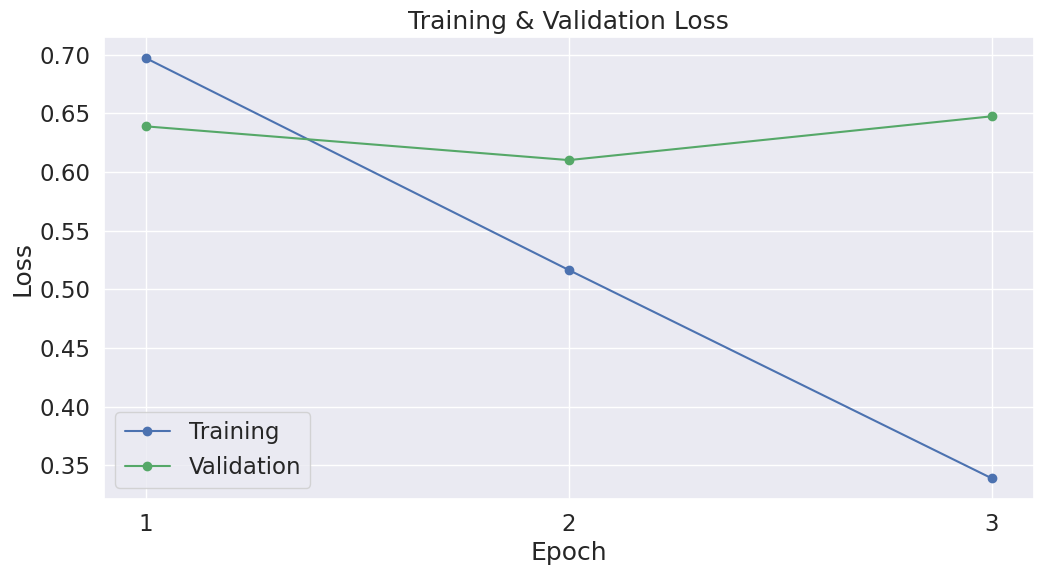

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_stats = pd.read_parquet(f"{output_dir}/training_stats.parquet")

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3])

plt.show()

13. Load and test the model.

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

device = torch.device("cuda"  if torch.cuda.is_available() else  "cpu")

tokenizer = AutoTokenizer.from_pretrained(output_dir)
aira = AutoModelForCausalLM.from_pretrained(output_dir)

aira.eval()
aira.to(device)

question =  input("Enter your question: ")

inputs = tokenizer(tokenizer.bos_token + question + tokenizer.eos_token, return_tensors="pt").to(device)

responses = aira.generate(**inputs,
    bos_token_id=tokenizer.bos_token_id,
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id,
    do_sample=True,
    top_k=50,
    max_length=200,
    top_p=0.95,
    temperature=0.7,
    num_return_sequences=2)

print(f"Question: 👤 {question}\n")

for i, response in  enumerate(responses):
    print(f'Response {i+1}: 🤖 {tokenizer.decode(response, skip_special_tokens=True).replace(question, "")}')


Question: 👤 What is an ethical dilemma?

Response 1: 🤖 An ethical dilemma is a dilemma that can be understood as a question about the right course of action to take, due to the variety of moral and ethical principles at play. It is a dilemma that can be categorized into three categories: consequentialism, deontology, and virtue ethics.
Response 2: 🤖 An ethical dilemma is a dilemma that requires a decision that is not a simple yes or no answer, but a complex discussion about the ethical or moral consequences of the choice. Examples of ethical dilemma can include the use of a trolley system in a city building, the use of a nuclear weapons system in a military field, or the use of a personal automobile in a parking lot. The decision-making process usually involves weighing the pros and cons of the various options and coming to a decision that is fair and just.


Done! 🤗